# **Elaborato per il corso di Hands on Labs, MD2SL 2024**
## **Rete comvoluzionale per super-risoluzione (in scala di grigi)**
## *Dario Comanducci*

## Dataset per super-risoluzione
In Dong et al. l'immagine ad alta risoluzione viene creata a partire da un'interpolazione bicubica alle dimensioni desiderate, creata a partire dall'immagine iniziale a bassa risoluzione.

Le immagini di Celeba sono state ridotte in dimensione per cercare di ridurre i tempi di elaborazione: in particolare,
* le immagini sono state prima ritagliate dalla dimensione originale 218$\times$178 alla dimensione quadrata 168$\times$168, con ritaglio centrato sull'immagine, ma tale da contenere il volto raffigurato in ciascuna foto;
* successivamente le immagini sono state sottocampionate alla dimensione 84$\times$84 (la nostra immagine ad alta risoluzione) e 28$\times$28 (immagine a bassa risoluzione, con fattore di scala 3$\times$ come in Dong et al.) tramite interpolazione bicubica
* le immagini 28$\times$28 sono state poi riportate alla dimensione di riferimento 84$\times$84, costituendo;
* similmente a Dong et al. infine le immagini 84$\times$84 sono state splittate in patch non sovrapposte della dimensione 28$\times$28 (ogni immagine 84$\times$84 produce quindi 9 patch);
* le 9 patch 28$\times$28 (leggermente più piccole delle 33$\times$33 usate in Dong et al.) della coppia a bassa/alta risoluzione di ciascuna immagine sono impiegate per il training e la validazione dell'addestramento.

Nonostante l'addestramento sia condotto su patch di dimensione 28$\times$28, l'architettura della rete è comunque tale da essere applicabile anche alle immagini a dimensione intera.

Le operazioni indicate vengono effettuate nella classe $\texttt{ImageGrayscaleDataset}$, che espone i seguenti metodi:
* un metodo statico _(imgLR, imgHR) = LoadLHRImages(img_dir, df_set)_ che carica in memoria le immagini dalla cartella img_dir, secondo gli indici forniti dal dataframe df_set (training set, validation set o test set), creando la versione in scala di grigi di 84$\times$84 pixel sia a bassa risoluzione (nella lista _imgLR_) che quella ad alta definizione (nella lista _imgHR_)
* il costruttore ___init__(self, X_data, y_data)_ prende quindi in ingresso le due liste imgLR (in _self.X_data_) e imgHR (in _self.y_Data_) scomponendo ogni immagine nelle 9 patch 28$\times$28, ciascuna delle quali costituisce un elemento del dataset nelle due liste _self.X_ e _self.y_ (le immagini complete vengono invece memorizzate in _self.img_X_ e _self.img_y_)
* la funzione _split_image(self, image, rows, cols)_ che divide l'immagine image nei blocchi rows$\times$cols
* l'override dei metodi ___getitem__(self, index)_ e ___len__ (self)_
* un metodo _getImages(self, index)_ che restituisce la coppia di immagini a bassa/alta risoluzione intere prese dalle liste _self.img_X_ e _self.img_y_, a differenza di ___getitem__(self, index)_ che invece restiuisce una singola patch
* infine una funzione _plotExample(self, item, showPacthes=False)_ che mostra sia la coppia di immagini a bassa/alta risoluzione nella loro interezza, sia anche nella versione spezzata in patch

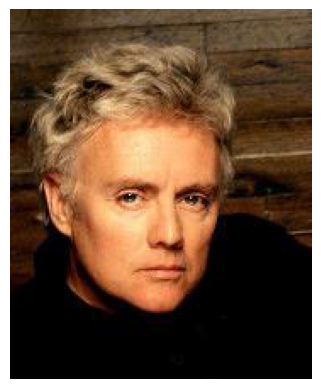

In [1]:
from os import path
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np

img_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/img_align_celeba/'
fid = '000030.jpg'
orig_img = Image.open(path.join(img_path, fid))
plt.imshow(np.array(orig_img))
plt.axis('off')
plt.show()

In [2]:
import pandas as pd
import datetime

from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor, ToPILImage, Compose, Normalize, InterpolationMode, v2

#normalizeGrayscale = Compose([ToTensor(), Normalize(0.5, 0.5)])
normalizeGrayscale = Compose([ToTensor()])

class ImageGrayscaleDataset(TensorDataset):
    
    # metodo statico per creare le immagini a bassa/alta risoluzione a partire dalla lista di immagini
    @staticmethod
    def LoadLHRImages(img_dir, df_set):
        img_names = df_set.index.values

        printed = -1
        counter = 0
        
        imgLR = []
        imgHR = []
        tot = len(img_names)
        first_time = datetime.datetime.now()
        for fid in img_names:
            img = Image.open(path.join(img_dir, fid))
            
            gray_img = v2.Grayscale()(img)
            cropped  = v2.CenterCrop(size=(168,168))(gray_img) 
            target   = v2.Resize(size=(84,84), interpolation=InterpolationMode.BICUBIC)(cropped)
            resized  = v2.Resize(size=(28,28), interpolation=InterpolationMode.BICUBIC)(cropped)
            interp   = v2.Resize(size=(84,84), interpolation=InterpolationMode.BICUBIC)(resized)
            
            imgLR.append(interp)
            imgHR.append(target)

            # mostra avanzamento del caricamento e stima del tempo rimasto
            counter += 1
            perc = counter/tot
            perc100 = np.floor(perc*10)*10
            if printed != perc100:
                printed = perc100
                later_time = datetime.datetime.now()
                diff = later_time - first_time
                toClose = diff*(tot-counter)/counter
                print('   # {}/{} ({}%) {}'.format(counter, tot, perc100, toClose))

        return (imgLR, imgHR)

#--------------------------------------------------------------------------------------------------------------------------    
    
    def __init__(self, X_data, y_data):
        nImgs = len(X_data)
        
        self.X = []
        self.y = []
        self.img_X = []
        self.img_y = []
        
        counter = 0
        printed = -1
        for k in range(nImgs):
            imgLR = X_data[k]
            imgHR = y_data[k]
            
            #self.img_X.append(ToTensor()(imgLR))
            self.img_X.append(normalizeGrayscale(imgLR))
            patches = self.split_image(imgLR,3,3)
            for p in patches:
                #self.X.append(ToTensor()(p))
                self.X.append(normalizeGrayscale(p))
            
            #self.img_y.append(ToTensor()(imgHR))
            self.img_y.append(normalizeGrayscale(imgHR))
            patches = self.split_image(imgHR,3,3)
            for p in patches:
                #self.y.append(ToTensor()(p))
                self.y.append(normalizeGrayscale(p))

            # mostra avanzamento della scomposizione in patch
            counter += 1
            perc = counter/nImgs
            perc100 = np.floor(perc*10)*10
            if printed != perc100:
                printed = perc100
                print('   # {}/{} ({}%)'.format(counter, nImgs, perc100))

#--------------------------------------------------------------------------------------------------------------------------
            
    def split_image(self, image, rows, cols):
        width, height = image.size
        patch_width = width // cols
        patch_height = height // rows
    
        patches = []
        for i in range(rows):
            for j in range(cols):
                x1 = j * patch_width
                y1 = i * patch_height
                x2 = x1 + patch_width
                y2 = y1 + patch_height
                patch = image.crop((x1, y1, x2, y2))
                patches.append(patch)
    
        return patches

#--------------------------------------------------------------------------------------------------------------------------
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

#--------------------------------------------------------------------------------------------------------------------------
    
    def __len__ (self):
        return len(self.X)
#--------------------------------------------------------------------------------------------------------------------------
    
    def getImages(self, index):
        return self.img_X[index], self.img_y[index]
    
#--------------------------------------------------------------------------------------------------------------------------

    def size(self):
        return len(self.X)

#--------------------------------------------------------------------------------------------------------------------------

    def examples(self):
        return len(self.img_X)

#--------------------------------------------------------------------------------------------------------------------------
    
    def plotExample(self, item, showPacthes=False):
        (X,y) = self.getImages(item)
        # denormalizzo le immagini
        #X = ImageGrayscaleDataset.denormalize(X)
        #y = ImageGrayscaleDataset.denormalize(y)
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(np.array(ToPILImage()(X)), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('input')
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(np.array(ToPILImage()(y)), cmap='gray', vmin=0, vmax=255)
        ax.set_title('target')
        ax.set_axis_off()
        plt.show()
    
        if showPacthes:
            
            fig, ax = plt.subplots(3,6, figsize=(6, 3)) #
            
            pos = item*9
            for i in range(3):
                for j in range(3):
                    sh = i*3+j

                    (Xp,yp) = self.__getitem__(pos+sh)
                    #Xp = ImageGrayscaleDataset.denormalize(Xp)
                    #yp = ImageGrayscaleDataset.denormalize(yp)
                    
                    ax[i,j].imshow(np.array(ToPILImage()(Xp)), cmap='gray', vmin=0, vmax=255)
                    ax[i,j].set_axis_off()
                    
                    ax[i,j+3].imshow(np.array(ToPILImage()(yp)), cmap='gray', vmin=0, vmax=255)
                    ax[i,j+3].set_axis_off()
    
    
            plt.tight_layout()
            plt.show()

    # @staticmethod
    # def denormalize(imgNorm):
    #     img = (imgNorm /2) + 0.5
    #     return img
        

Carichiamo quindi in memoria training set e validation set, mostrando un esempio per ciascuno di essi


TRAINING SET
   # 1/16277 (0.0%) 0:00:41.813044
   # 1628/16277 (10.0%) 0:00:16.609096
   # 3256/16277 (20.0%) 0:00:14.660370
   # 4884/16277 (30.0%) 0:00:12.978204
   # 6511/16277 (40.0%) 0:00:11.002040
   # 8139/16277 (50.0%) 0:00:09.150741
   # 9767/16277 (60.0%) 0:00:07.288316
   # 11394/16277 (70.0%) 0:00:05.433894
   # 13022/16277 (80.0%) 0:00:03.633931
   # 14650/16277 (90.0%) 0:00:01.805905
   # 16277/16277 (100.0%) 0:00:00
   # 1/16277 (0.0%)
   # 1628/16277 (10.0%)
   # 3256/16277 (20.0%)
   # 4884/16277 (30.0%)
   # 6511/16277 (40.0%)
   # 8139/16277 (50.0%)
   # 9767/16277 (60.0%)
   # 11394/16277 (70.0%)
   # 13022/16277 (80.0%)
   # 14650/16277 (90.0%)
   # 16277/16277 (100.0%)
0:00:27.062887


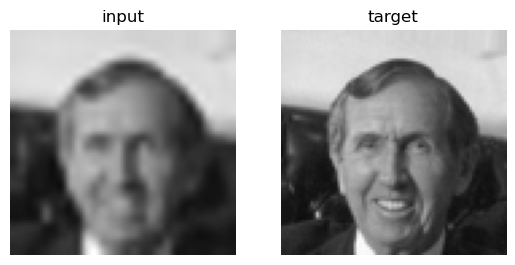

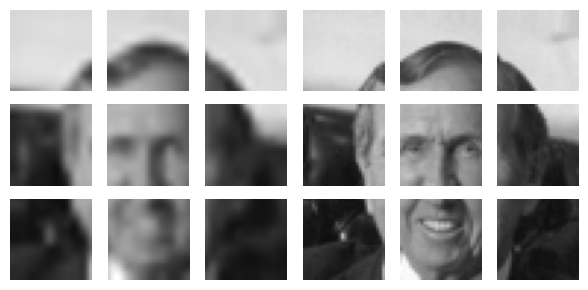


VALIDATION SET
   # 1/1987 (0.0%) 0:00:23.113068
   # 199/1987 (10.0%) 0:00:01.990206
   # 398/1987 (20.0%) 0:00:01.720987
   # 597/1987 (30.0%) 0:00:01.484804
   # 795/1987 (40.0%) 0:00:01.266733
   # 994/1987 (50.0%) 0:00:01.073884
   # 1193/1987 (60.0%) 0:00:00.857592
   # 1391/1987 (70.0%) 0:00:00.642254
   # 1590/1987 (80.0%) 0:00:00.429334
   # 1789/1987 (90.0%) 0:00:00.213425
   # 1987/1987 (100.0%) 0:00:00
   # 1/1987 (0.0%)
   # 199/1987 (10.0%)
   # 398/1987 (20.0%)
   # 597/1987 (30.0%)
   # 795/1987 (40.0%)
   # 994/1987 (50.0%)
   # 1193/1987 (60.0%)
   # 1391/1987 (70.0%)
   # 1590/1987 (80.0%)
   # 1789/1987 (90.0%)
   # 1987/1987 (100.0%)
0:00:03.351129


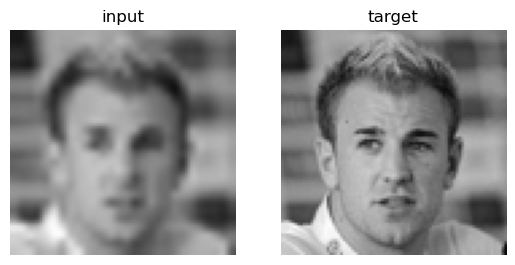

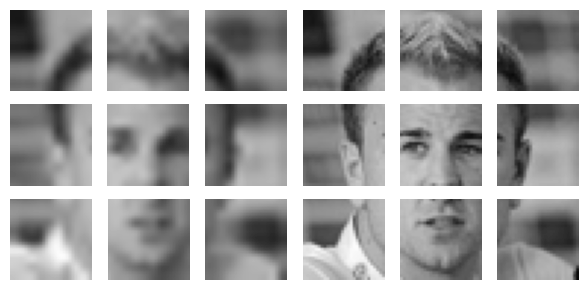

In [3]:
fpath = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/CelebA/'
df_part = pd.read_csv(fpath + 'list_eval_partition.txt', sep=" ", index_col=0, header=None, names=['set'])

img_path = 'C:/Users/dario/Documents/Projects/Master/HandsOnLab/img_align_celeba/'
set_labels = {0: 'train', 1: 'valid', 2: 'test'}
df_part['set'] = df_part['set'].replace(set_labels)
idTrain = df_part[df_part['set'] == 'train'].index
idValid = df_part[df_part['set'] == 'valid'].index

df_train = df_part.loc[idTrain[::10]]
df_valid = df_part.loc[idValid[::10]]

print('\nTRAINING SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageGrayscaleDataset.LoadLHRImages(img_path, df_train)
trGrayDataset = ImageGrayscaleDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
trGrayDataset.plotExample(2, True)

print('\nVALIDATION SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageGrayscaleDataset.LoadLHRImages(img_path, df_valid)
vlGrayDataset = ImageGrayscaleDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
vlGrayDataset.plotExample(2, True)


## La rete convoluzionale

La rete proposta in Dong et al. è composta tra 3 layer convoluzionali con kernel di dimensione $c_k \times f_k \times f_k$, il cui output è formato da $n_k$ "immagini" convolute ($k=1,2,3$ andando dall'ingresso verso l'uscita); in particolare
* $n_1=64$, $f_1 = 9$, $c_1 = 1$
* $n_2=32$, $f_2 = 1$, $c_2 = 64$
* $n_3=1$, $f_3 = 5$, $c_3 = 32$

Al risultato di ciascuna convoluzione è poi sommato un bias, ed infine applicata la ReLU $\max(0,x)$ come funzione d'attivazione.

L'implementazione di tale rete è costituita dalla classe $\texttt{GrayCNN}$, in cui vengono definiti il costruttore ___init___ (con la creazione dei kernel e delle funzioni di attivazione per ciascun layer) ed il metodo _forward()_ che concatena il flusso di calcolo

In [11]:
import torch.nn as nn

class GrayCNN(nn.Module):
    
    def __init__(self):
        super(GrayCNN, self).__init__()
        #NB: bias=True in nn.Conv2d come default
        
        # layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, stride=1, padding=4, padding_mode='reflect')
        self.relu1 = nn.ReLU()

        # Layer 2
        self.cnn2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
        self.relu2 = nn.ReLU()

        # Layer 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, stride=1, padding=2, padding_mode='reflect')
        self.relu3 = nn.ReLU()
        
#--------------------------------------------------------------------------------------------------------------------------
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)

        return out


## Addestramento

L'addestramento, implementato nella funzione $\texttt{train()}$ avviene nella maniera "classica", in cui la rete viene tarata sugli esempi del traning set, e valutata la sua prestazione sul validation set.

I parametri che solitamente si specificano per $\texttt{train()}$ sono:
* il modello _model_ con la rete da addestrare
* il metodo di ottimizzazione in _optimizer_
* la funzione di costo _loss_fn_ da minimizzare
* gli oggetti _train_loader_ e _val_loader_ adibiti al passaggio degli esempi in ogni epoca
* il numero di epoche di addestramento da eseguire
* il _device_ (cpu o gpu) su cui far girare l'elaborazione della rete

In aggiunta a quanto detto, la funzione $\texttt{train()}$ qui implementata accetta un oggetto opzionale _monitor_, istanza della classe $\texttt{Monitor}$ definita di seguito, impiegato per monitorare e loggare lo stato dell'addestramento secondo lo standard di Tensorboard.


In [13]:
import torch.cuda
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

class Monitor:
    
    def __init__(self, dataset, idExample=None, saveNet=False):
        self.dataset = dataset
        self.idExample = idExample
        self.createWriter(saveNet)

#--------------------------------------------------------------------------------------------------------------------------
    
    def createWriter(self, saveNet):
        folder1 = datetime.datetime.now().strftime("./runs/%b%d_%H-%M-%S_Godel/")
        self.writer = SummaryWriter()
        folder2 = datetime.datetime.now().strftime("./runs/%b%d_%H-%M-%S_Godel/")        

        # path di salvataggio della rete corrente, fatto in modo da essere nella stessa cartella dove logga writer
        if saveNet:
            if path.exists(folder1):
                folder = folder1
            else:
                folder = folder2    
            self.RPATH = folder + 'CvNet_' 
        else:
            self.RPATH = ""

#--------------------------------------------------------------------------------------------------------------------------
    
    def annotateLoss(self, training_loss, valid_loss, epoch):
        self.writer.add_scalar("Loss/train", training_loss, epoch)
        self.writer.add_scalar("Loss/valid", valid_loss, epoch)

#--------------------------------------------------------------------------------------------------------------------------
    
    def annotatePrediction(self, model, device, epoch):
        if self.idExample != None:
            (X,y) = self.dataset.getImages(self.idExample)
            p = model(X.to(device))
            img_grid = make_grid([X.to(device),p.to(device),y.to(device)])
            #Xn = ImageGrayscaleDataset.denormalize(X)
            #yn = ImageGrayscaleDataset.denormalize(y)
            #pn = ImageGrayscaleDataset.denormalize(p)
            #img_grid = make_grid([X.to(device),p.to(device),y.to(device)])
            self.writer.add_image('prediction check', img_grid, epoch)

#--------------------------------------------------------------------------------------------------------------------------
    
    def saveNet(self, model, epoch):
        if len(self.RPATH) != 0:
            fname = self.RPATH + str(epoch)
            torch.save(model.state_dict(), fname)

#--------------------------------------------------------------------------------------------------------------------------
    
    @staticmethod
    def createSummary(lr, batch_size, training_size, training_loss, valid_loss, seed):
        summary = {'lr':lr, 'bsize':batch_size, 'tsize':training_size, 'tloss':training_loss, 'vloss':valid_loss, 'seed':seed}
        return summary

#--------------------------------------------------------------------------------------------------------------------------
    
    def close(self, summary): 
        self.writer.flush()
        self.writer.add_hparams({'seed':summary['seed'], 'lr':summary['lr'],  'bsize':summary['bsize'], 'tsize':summary['tsize']}, 
                                {'hparam/tloss': summary['tloss'], 'hparam/vloss': summary['vloss']})
        self.writer.flush()
        self.writer.close()

#___________________________________________________________________________________________________________________________

def train(model, optimizer, loss_fn, train_loader, val_loader, epochs, device="cpu", monitor=None):
    
    model.to(device)
    
    trLossVals = []
    vlLossVals = []
    for epoch in range(1, epochs+1):
        
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad() # clear gradients for next train
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward() # backpropagation, compute gradients
            optimizer.step() # apply gradients
            training_loss += loss.data.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)

        with torch.no_grad():
            model.eval()

            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                output = model(inputs)
                targets = targets.to(device)
                loss = loss_fn(output,targets)
                valid_loss += loss.data.item() * inputs.size(0)
              
            valid_loss /= len(val_loader.dataset)

            if monitor != None:
                monitor.saveNet(model, epoch)
                monitor.annotatePrediction(model, device, epoch)
                monitor.annotateLoss(training_loss, valid_loss, epoch)

        print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, training_loss, valid_loss))
        
        trLossVals.append(training_loss)
        vlLossVals.append(valid_loss)
        
    return (trLossVals, vlLossVals)


## Cross-validazione?

In [6]:
import random
mySeed = 313

print('GPU cuda {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

lr_vals = [0.00001, 0.0001]
batch_vals = [128, 64, 32]
nEpochs = 150


crResults = []
for lr in lr_vals:
    for batch_size in batch_vals:
        
        print('______________________________________________________________')
        print('LEARNING RATE {} -- BATCH SIZE {}'.format(lr, batch_size))

        # per riprodurre gli stessi risultati
        random.seed(mySeed)
        torch.manual_seed(mySeed)
        np.random.seed(mySeed) 

        train_dl = DataLoader(trGrayDataset, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(vlGrayDataset, batch_size=batch_size, shuffle=True)

        grayCnn = GrayCNN()
        optimizer = optim.Adam(grayCnn.parameters(), lr=lr)
        
        monitor = Monitor(dataset=vlGrayDataset, idExample=3, saveNet=False)
        training_loss, valid_loss = train(grayCnn, optimizer, nn.MSELoss(), train_dl, val_dl, nEpochs, device, monitor) 
        
        summary = Monitor.createSummary(lr, batch_size, train_dl.dataset.size(), np.min(training_loss), np.min(valid_loss), mySeed)
        monitor.close(summary)

        summary['ts_tloss'] = training_loss
        summary['ts_vloss'] = valid_loss
        crResults.append(summary)


GPU cuda True
______________________________________________________________
LEARNING RATE 1e-05 -- BATCH SIZE 128
Epoch: 1, Training Loss: 0.0433, Validation Loss: 0.0063
Epoch: 2, Training Loss: 0.0047, Validation Loss: 0.0037
Epoch: 3, Training Loss: 0.0034, Validation Loss: 0.0032
Epoch: 4, Training Loss: 0.0030, Validation Loss: 0.0028
Epoch: 5, Training Loss: 0.0027, Validation Loss: 0.0026
Epoch: 6, Training Loss: 0.0025, Validation Loss: 0.0025
Epoch: 7, Training Loss: 0.0024, Validation Loss: 0.0024
Epoch: 8, Training Loss: 0.0024, Validation Loss: 0.0023
Epoch: 9, Training Loss: 0.0023, Validation Loss: 0.0023
Epoch: 10, Training Loss: 0.0023, Validation Loss: 0.0023
Epoch: 11, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch: 12, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch: 13, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch: 14, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch: 15, Training Loss: 0.0022, Validation Loss: 0.0022
Epoch: 16, Training Loss

### Visualizzazione delle curve di apprendimento

In [10]:
def visualizeLossTrend(crResults, lr_vals, batch_vals, ylim=[0.001, 0.005]):
    palette = colormaps['tab10']
    nColors = len(batch_vals)
    if nColors == 1:
        divPalette = 1
    else:
        divPalette = nColors-1
    colors = []
    for c in range(nColors):
        rgba = palette(c/divPalette)
        colors.append(rgba[0:3])

    fig, axes = plt.subplots(len(lr_vals), 2, figsize=(12, 10))
    for res in crResults:
        lr = res['lr']
        idlr = lr_vals.index(lr)
        idbs = batch_vals.index(res['bsize'])    
        epochs = range(len(res['ts_tloss']))
        
         
        if len(lr_vals)==1: 
            ax=axes[0];
        else:
            ax = axes[idlr,0];
        drawTrend(ax, epochs, res['ts_tloss'], colors[idbs], lr, lab=str(res['bsize']), ylim=ylim) 
        
        if len(lr_vals)==1: 
            ax=axes[1];
        else:
            ax = axes[idlr,1];
        if len(lr_vals)==1: ax=axes[1]    
        drawTrend(ax, epochs, res['ts_vloss'], colors[idbs], lr, lab=str(res['bsize']), ylim=ylim) 
    plt.tight_layout()
    plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------

def drawTrend(ax, epochs, ts, col, lr, lab, ylim): #ts=res['ts_tloss'], lab=str(res['bsize']), ylim=(0.001, 0.005)
        ax.plot(epochs, ts, color=col, label=lab)
        ax.set_ylim(ylim[0],ylim[1])
        ax.set_xlim(0, np.max(epochs))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(color='gray', linestyle=':', linewidth=0.5)
        ax.set_title('Training loss (learning rate {})'.format(lr))
        ax.set_xlabel('epochs')
        ax.set_ylabel('MSE')
        ax.legend(title='batch size')


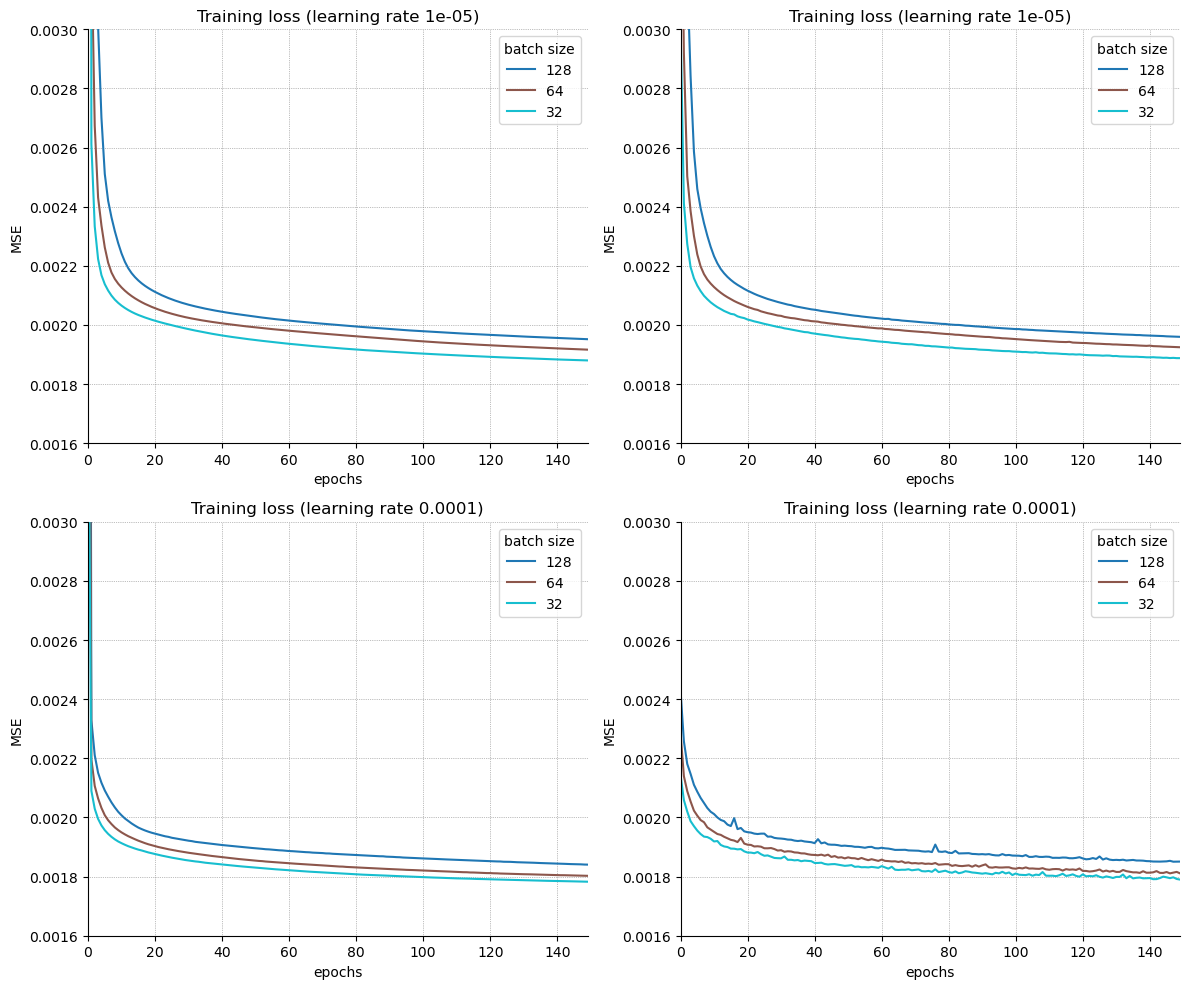

In [13]:

visualizeLossTrend(crResults, lr_vals, batch_vals,ylim=[0.0016,0.0030])


## Addestramento finale
La configurazione con learning rate lr=1e-4, e batch_size = 32 sembra produrre il miglior risultato. Tuttavia dal monitoraggio su Tensorboard risulta anche un tempo di addestramento pari al doppio delle altre run: per "pragmaticità" di esecuzione, si preferisce quindi impostare l'addestramento completo con la coppia lr=1e-4, batch_size=64 per non rischiare tempi di addestramento eccessivamente elevati.
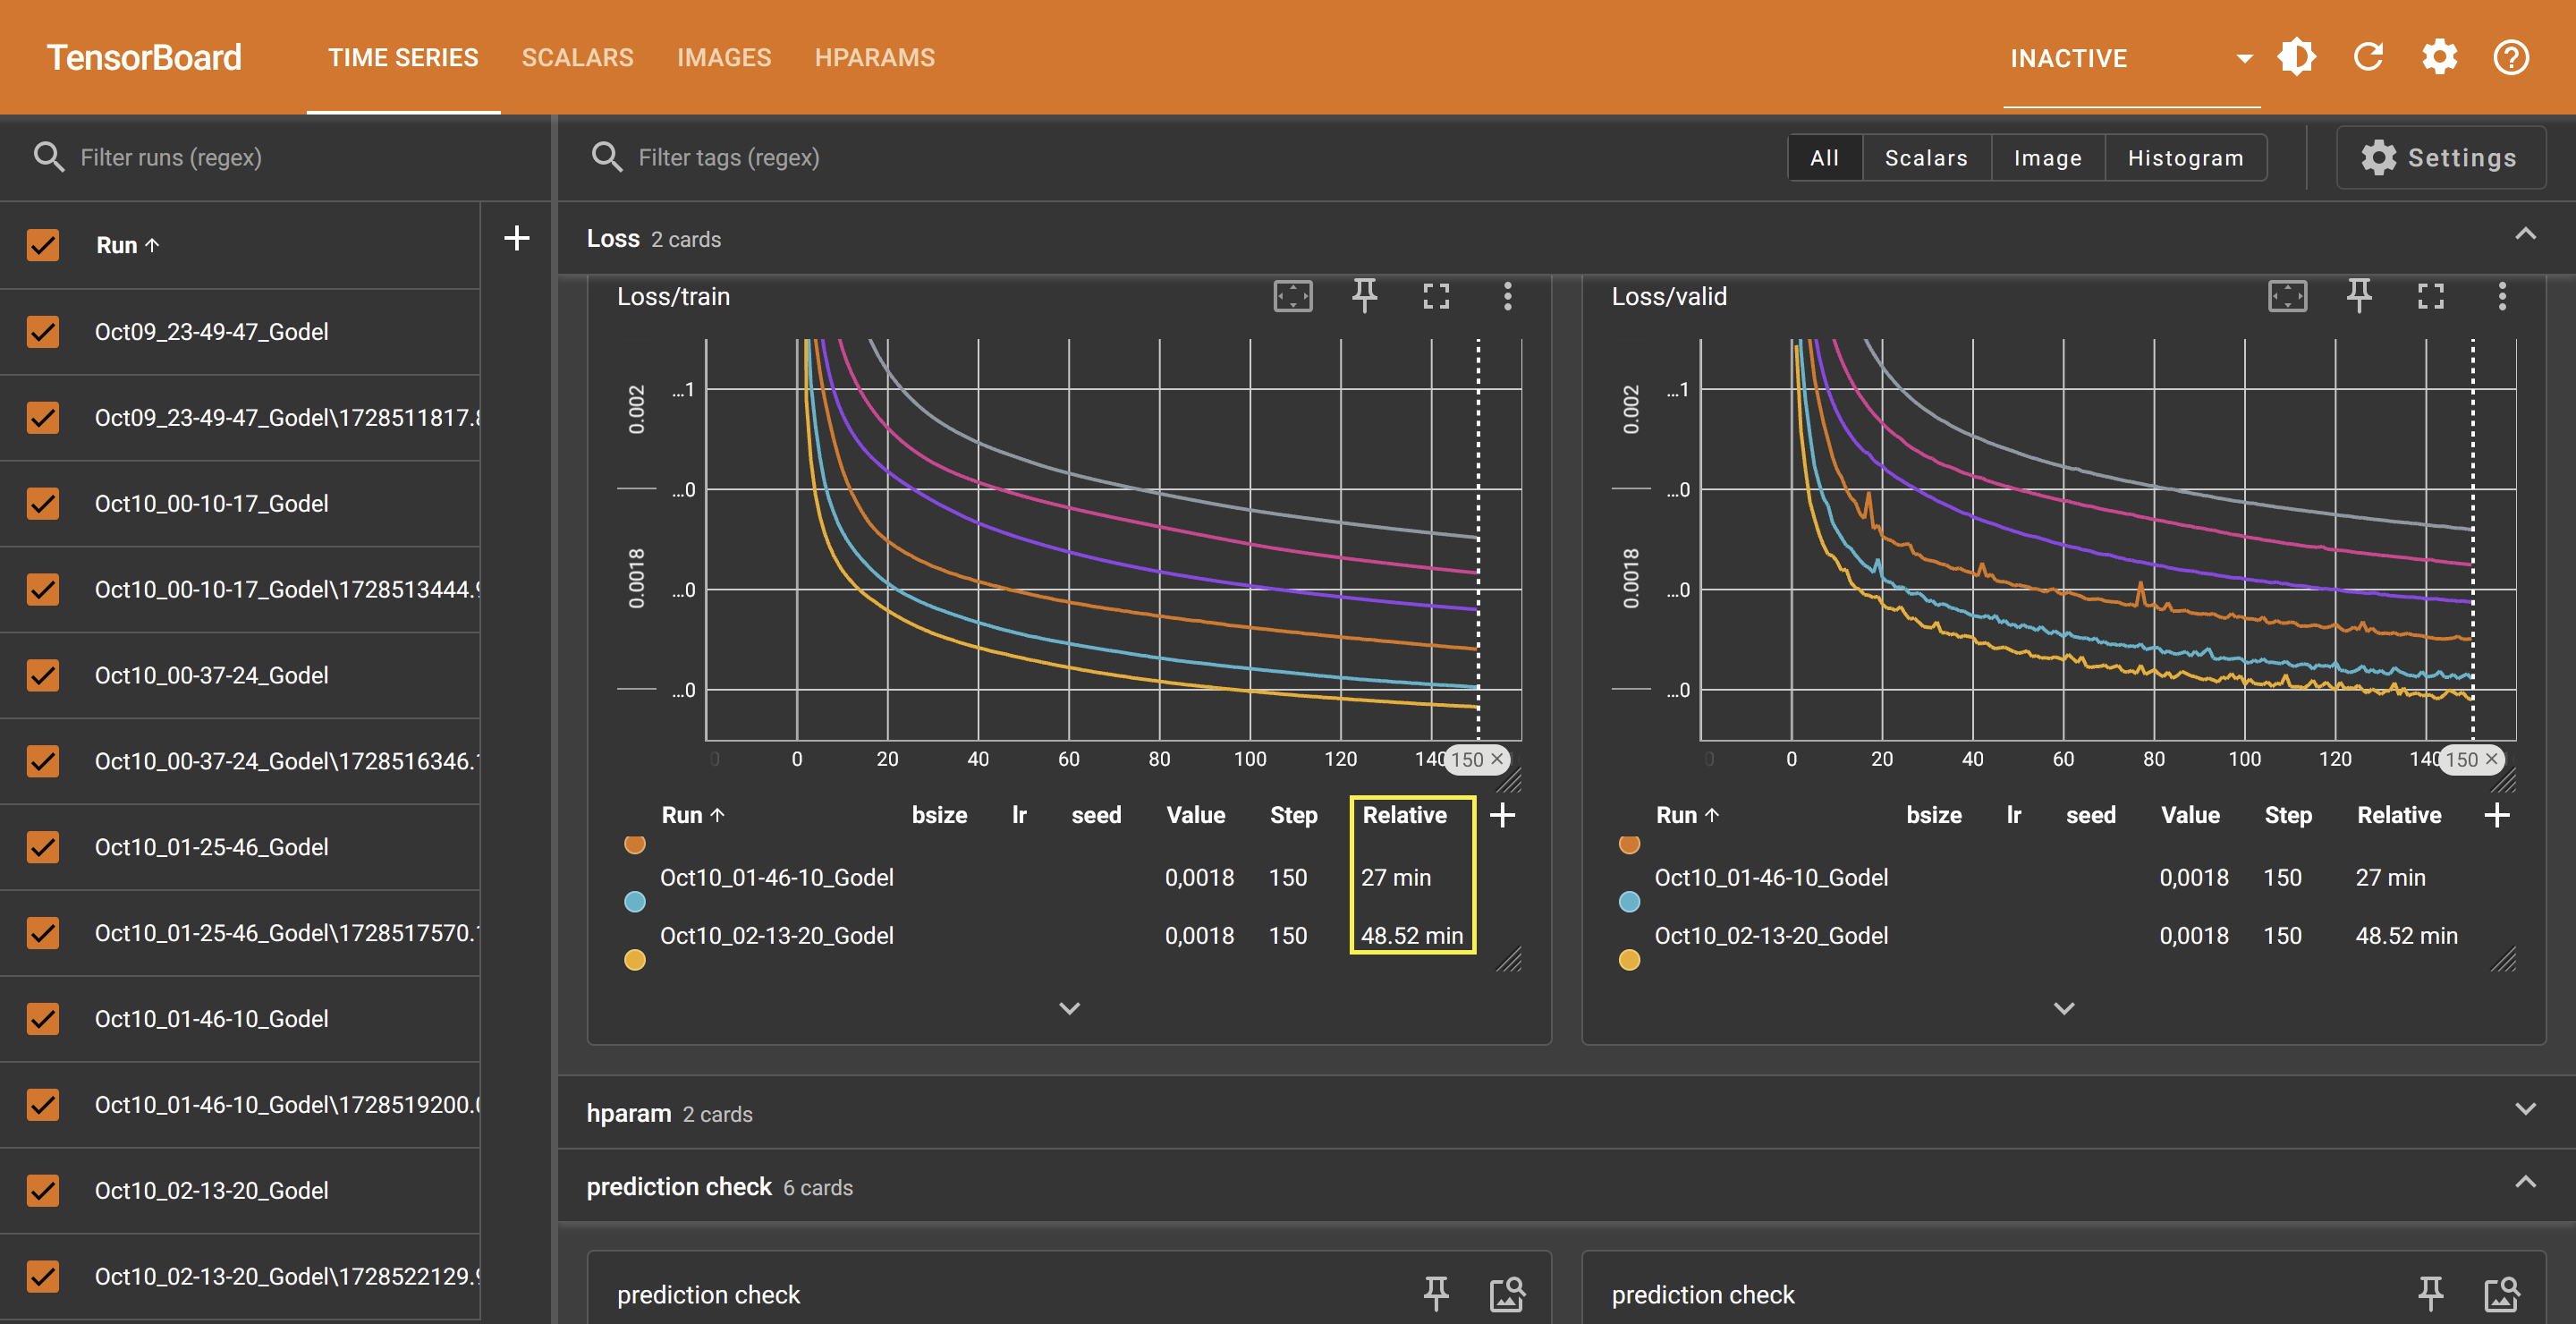

Inoltre, sempre per motivi pratici, il dataset di addestramento viene caricato solo per metà (una foto ogni 2, per un totale di 81385 immagini), in quanto si è visto che durante il suo caricamento completo la memoria era arrivata a oltre 27 GB pur non essendo ancora giunto in fondo sui 32 disponibili sulla macchina. Il dataset di validazione viene invece impiegato nella sua versione completa (19867 immagini).

Il numero di epoche viene leggermente aumentato, portandolo da 150 (valore usato nella cross-validazione) a 200.

In [4]:
df_train = df_part.loc[idTrain[::2]]
df_valid = df_part.loc[idValid]

print('\nTRAINING SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageGrayscaleDataset.LoadLHRImages(img_path, df_train)
trGrayDataset = ImageGrayscaleDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)

print('\nVALIDATION SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageGrayscaleDataset.LoadLHRImages(img_path, df_valid)
vlGrayDataset = ImageGrayscaleDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)


TRAINING SET
   # 1/81385 (0.0%) 0:00:00
   # 8139/81385 (10.0%) 0:01:10.012737
   # 16277/81385 (20.0%) 0:01:01.812168
   # 24416/81385 (30.0%) 0:00:53.811458
   # 32554/81385 (40.0%) 0:00:46.395218
   # 40693/81385 (50.0%) 0:00:38.651632
   # 48831/81385 (60.0%) 0:00:30.948443
   # 56970/81385 (70.0%) 0:00:23.228209
   # 65108/81385 (80.0%) 0:00:15.490226
   # 73247/81385 (90.0%) 0:00:07.761118
   # 81385/81385 (100.0%) 0:00:00
   # 1/81385 (0.0%)
   # 8139/81385 (10.0%)
   # 16277/81385 (20.0%)
   # 24416/81385 (30.0%)
   # 32554/81385 (40.0%)
   # 40693/81385 (50.0%)
   # 48831/81385 (60.0%)
   # 56970/81385 (70.0%)
   # 65108/81385 (80.0%)
   # 73247/81385 (90.0%)
   # 81385/81385 (100.0%)
0:02:10.750173

VALIDATION SET
   # 1/19867 (0.0%) 0:01:38.833350
   # 1987/19867 (10.0%) 0:00:17.034088
   # 3974/19867 (20.0%) 0:00:15.356901
   # 5961/19867 (30.0%) 0:00:13.497857
   # 7947/19867 (40.0%) 0:00:11.513081
   # 9934/19867 (50.0%) 0:00:09.570745
   # 11921/19867 (60.0%) 0:00:07.6

In [16]:
import random
mySeed = 313

print('GPU cuda {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

random.seed(mySeed)
torch.manual_seed(mySeed)
np.random.seed(mySeed) 

nEpochs = 200
lr = 0.0001
batch_size = 64

train_dl = DataLoader(trGrayDataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(vlGrayDataset, batch_size=batch_size, shuffle=True)

grayCnn = GrayCNN()
optimizer = optim.Adam(grayCnn.parameters(), lr=lr)

monitor = Monitor(dataset=vlGrayDataset, idExample=3, saveNet=True)
training_loss, valid_loss = train(grayCnn, optimizer, nn.MSELoss(), train_dl, val_dl, nEpochs, device, monitor) 

summary = Monitor.createSummary(lr, batch_size, train_dl.dataset.size(), np.min(training_loss), np.min(valid_loss), mySeed)
monitor.close(summary)


GPU cuda True
Epoch: 1, Training Loss: 0.0027, Validation Loss: 0.0020
Epoch: 2, Training Loss: 0.0020, Validation Loss: 0.0020
Epoch: 3, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 4, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 5, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 6, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 7, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 8, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 9, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 10, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 11, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 12, Training Loss: 0.0018, Validation Loss: 0.0019
Epoch: 13, Training Loss: 0.0018, Validation Loss: 0.0019
Epoch: 14, Training Loss: 0.0018, Validation Loss: 0.0019
Epoch: 15, Training Loss: 0.0018, Validation Loss: 0.0019
Epoch: 16, Training Loss: 0.0018, Validation Loss: 0.0019
Epoch: 17, Training Loss: 0.0018, Validation Loss: 0.0018
Epoch: 18

Lo screenshot di Tensorboard mostra come l'addestramento sul dataset "completo" abbia prodotto una curva di apprendimento per la loss function più bassa rispetto al caso sul dataset decimato.
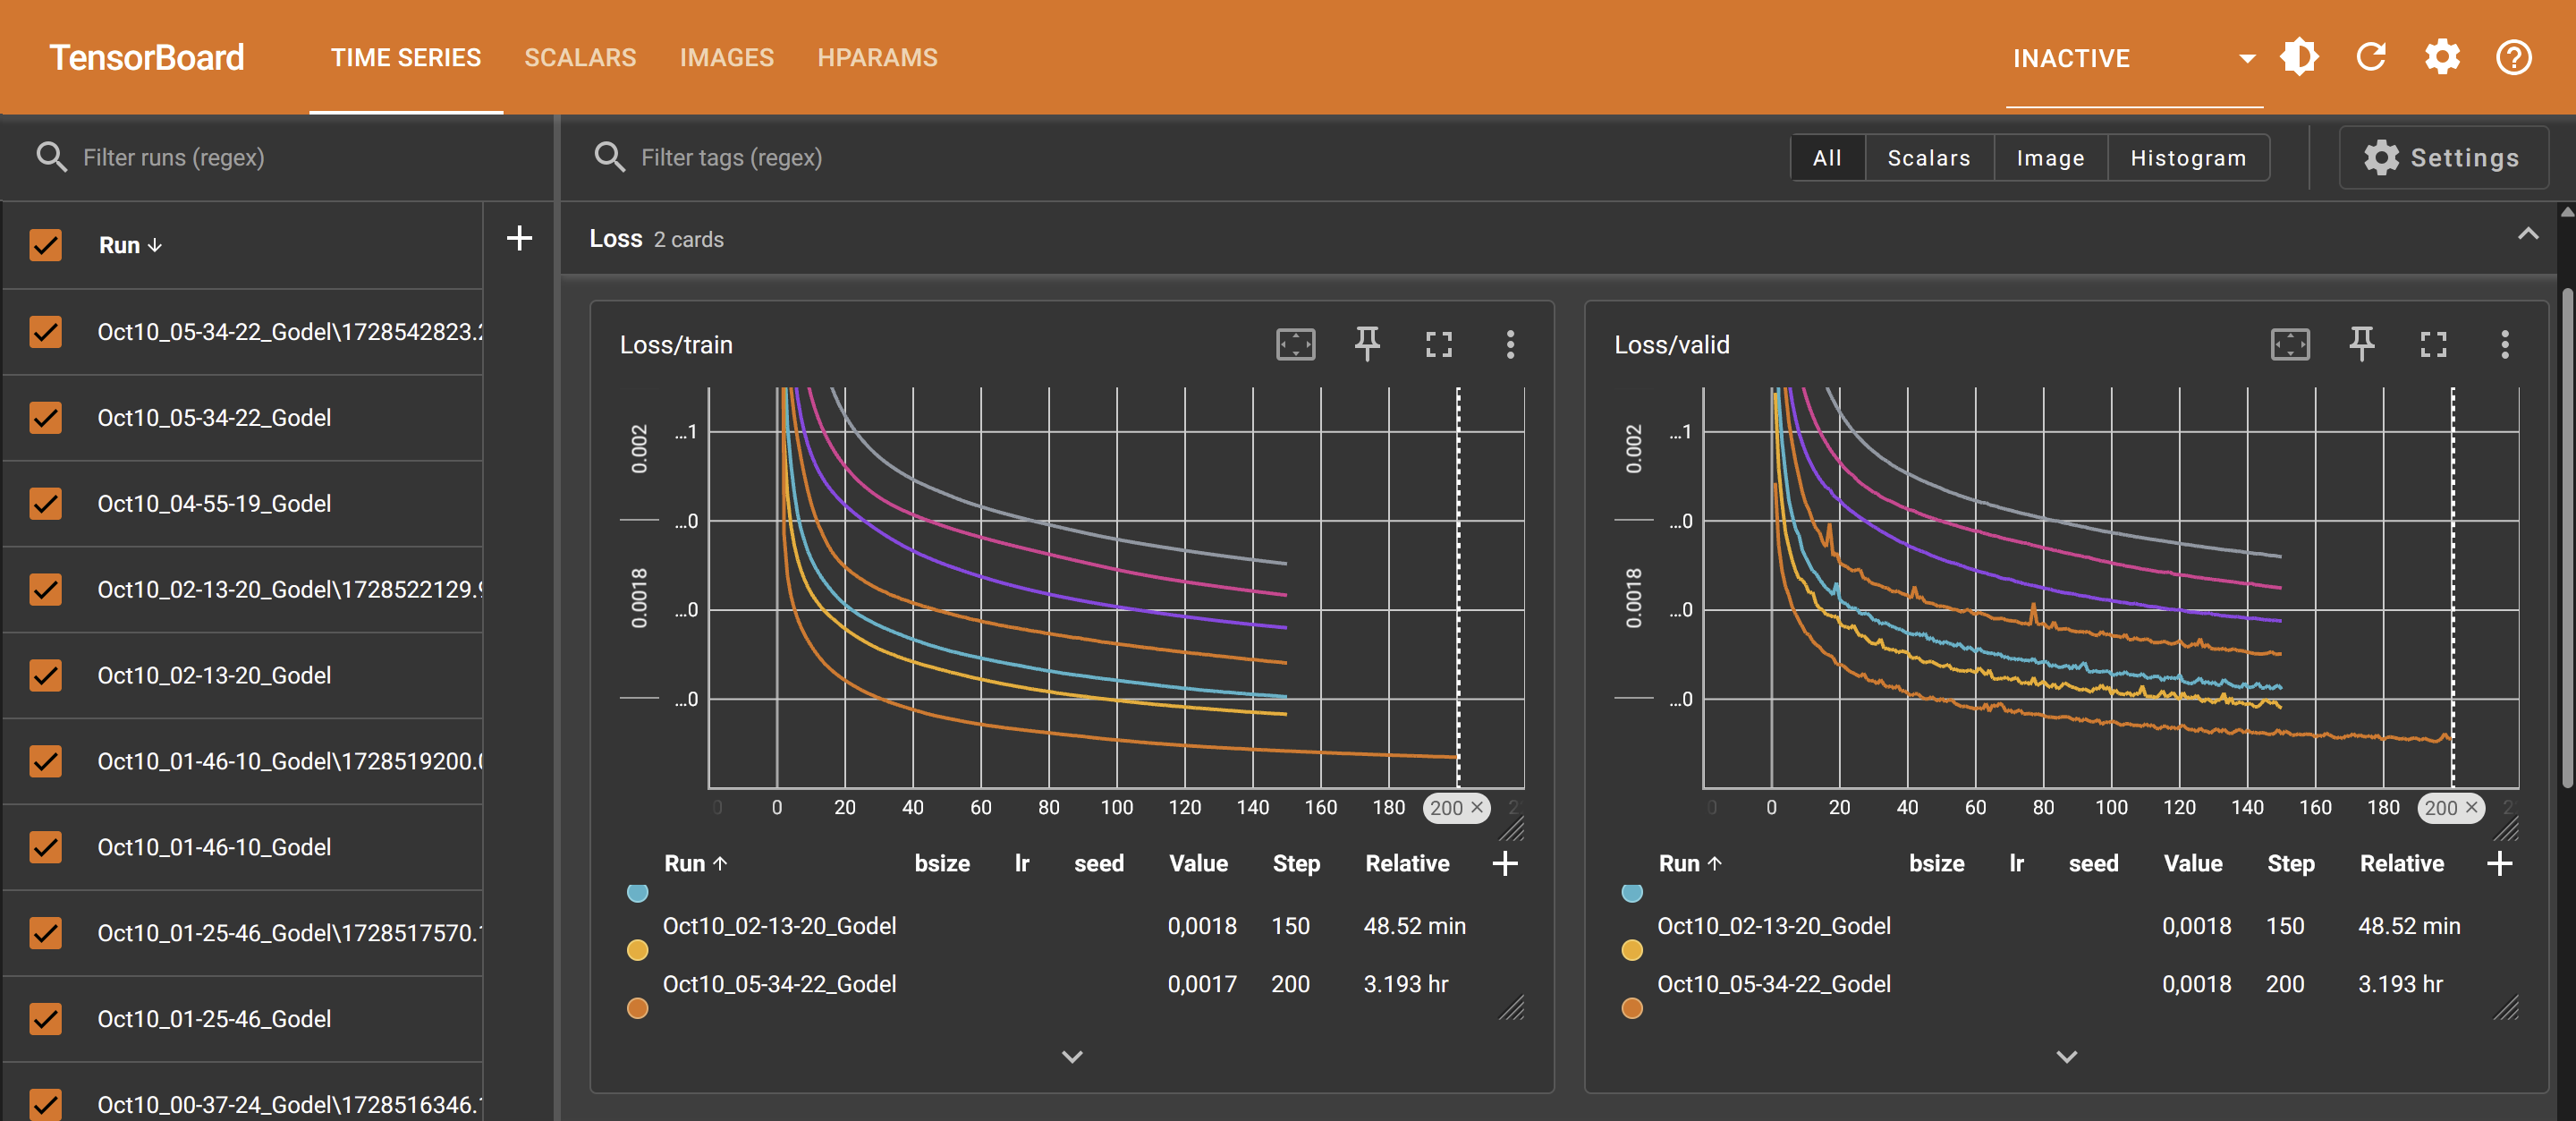

## Valutazione sul test set

L'addestramento è stato condotto minimizzando sul training set (e monitorando sul validation set) la loss function MSE, in analogia a quanto fatto da Dong et al. 

Per misurare la qualità dell'immagine prodotta dalla rete rispetto all'immagine in ingresso Dong et al. hanno preferito impiegare il _Peak Signal to Noise Ratio_ (PSNR) definito come
\begin{equation}
PSNR = 10 \log_{10} \frac{N\, L^2}{\sum_{n=1}^N (p_k-\hat{p}_k)^2} = 10 (\log_{10} L^2 - \log_{10}MSE)
\end{equation}
dove $p_k,\, \hat{p}_k$ rappresentano rispettivamente il pixel originale e quello stimato/interpolato (formula presa da Z. Wang, J. CHen, and S.C.H. Hoi, "Deep Learning for Image Super-resolution: A Survey" in _IEEE Transactions on Pattern Analysis and Machine Intelligence,_ 43(10):3365-3387, 2021).

Solitamente per le immagini L=255; tuttavia, impiegando qui un range tra 0 e 1, abbiamo che L=1 per cui nel nostro caso $PSNR=-10 \log_{10} MSE$.


TEST SET
   # 1/19962 (0.0%) 0:00:00
   # 1997/19962 (10.0%) 0:00:17.433562
   # 3993/19962 (20.0%) 0:00:15.340626
   # 5989/19962 (30.0%) 0:00:13.377973
   # 7985/19962 (40.0%) 0:00:11.417628
   # 9981/19962 (50.0%) 0:00:09.502446
   # 11978/19962 (60.0%) 0:00:07.601187
   # 13974/19962 (70.0%) 0:00:05.697093
   # 15970/19962 (80.0%) 0:00:03.802034
   # 17966/19962 (90.0%) 0:00:01.905337
   # 19962/19962 (100.0%) 0:00:00
   # 1/19962 (0.0%)
   # 1997/19962 (10.0%)
   # 3993/19962 (20.0%)
   # 5989/19962 (30.0%)
   # 7985/19962 (40.0%)
   # 9981/19962 (50.0%)
   # 11978/19962 (60.0%)
   # 13974/19962 (70.0%)
   # 15970/19962 (80.0%)
   # 17966/19962 (90.0%)
   # 19962/19962 (100.0%)
0:00:34.887223


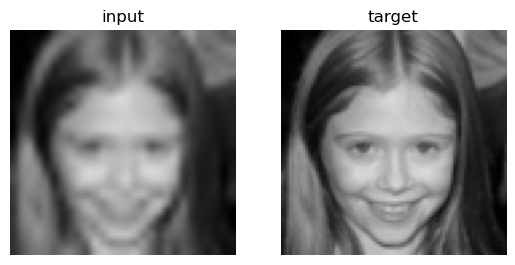

In [5]:
idTest = df_part[df_part['set']=='test'].index
df_test  = df_part.loc[idTest]
print('\nTEST SET')
start_time = datetime.datetime.now()
imgLR, imgHR = ImageGrayscaleDataset.LoadLHRImages(img_path, df_test)
teGrayDataset = ImageGrayscaleDataset(imgLR, imgHR)
stop_time = datetime.datetime.now()
print(stop_time - start_time)
teGrayDataset.plotExample(2, False)

In [6]:
import seaborn as sns

def PSNR(img1, img2):
    # L = 1 #255
    img1 = np.array(ToPILImage()(img1)).astype(np.float64)#*L
    img2 = np.array(ToPILImage()(img2)).astype(np.float64)#*L
    mse = np.mean((img1 - img2)**2)
    # psnr = 10 * np.log10(L*L/mse)
    psnr = -10*np.log10(mse)
    return psnr

def comparePSNR(dataset, model, title, xlim=None):
    psnrIn = []
    psnrOut = []
    counter = 0
    printed = 0
    nImgs = dataset.examples()
    for k in range(nImgs):
        lr,hr = dataset.getImages(k)
        pred = model(lr)
        psnrIn.append(PSNR(lr,hr))
        psnrOut.append(PSNR(pred,hr))

        # mostra avanzamento della scomposizione in patch
        counter += 1
        perc = counter/nImgs
        perc100 = np.floor(perc*10)*10
        if printed != perc100:
            printed = perc100
            print('   # {}/{} ({}%)'.format(counter, nImgs, perc100))


    fig, ax = plt.subplots(1, 1, figsize=(8, 4.94))
    sns.histplot(psnrIn,  stat='density', ax=ax, color='cornflowerblue', edgecolor='#005e93',    label='input')
    sns.histplot(psnrOut, stat='density', ax=ax, color='orange',         edgecolor='darkorange', label='output')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', color='white', linewidth=1)
    ax.set_xlabel('PSNR')
    ax.legend(title='batch size')
    ax.set_title(title)
    if xlim != None:
        ax.set_xlim(xlim[0],xlim[1])
    plt.show()

    return (psnrIn, psnrOut)

   # 1997/19962 (10.0%)
   # 3993/19962 (20.0%)
   # 5989/19962 (30.0%)
   # 7985/19962 (40.0%)
   # 9981/19962 (50.0%)
   # 11978/19962 (60.0%)
   # 13974/19962 (70.0%)
   # 15970/19962 (80.0%)
   # 17966/19962 (90.0%)
   # 19962/19962 (100.0%)


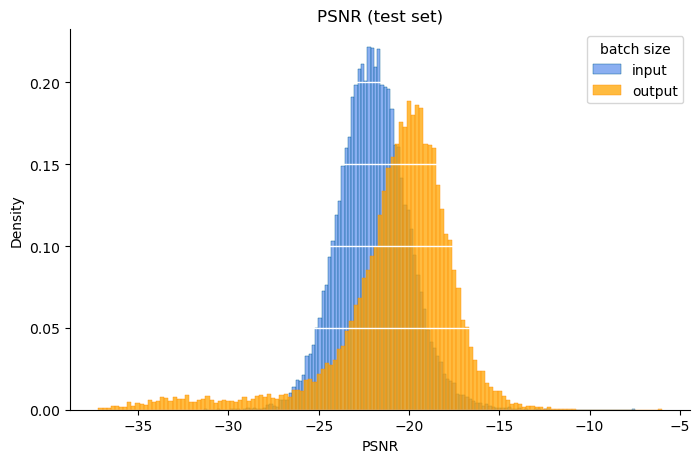

PSNR input (avg:-21.97 std.dev:1.91) vs PSNR output (avg:-20.74 std.dev:3.40)
   # 1987/19867 (10.0%)
   # 3974/19867 (20.0%)
   # 5961/19867 (30.0%)
   # 7947/19867 (40.0%)
   # 9934/19867 (50.0%)
   # 11921/19867 (60.0%)
   # 13907/19867 (70.0%)
   # 15894/19867 (80.0%)
   # 17881/19867 (90.0%)
   # 19867/19867 (100.0%)


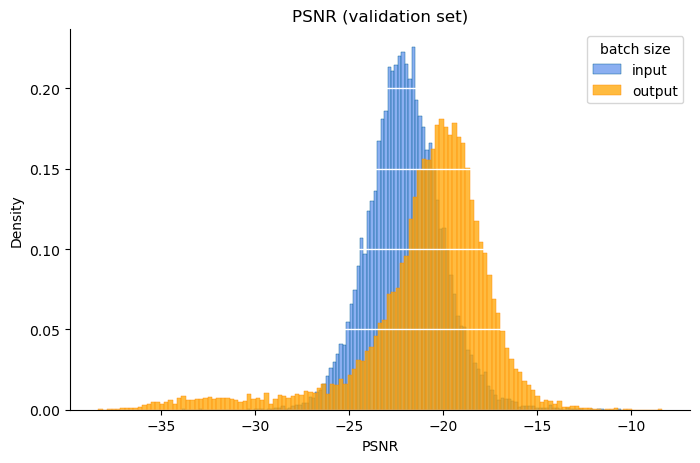

PSNR input (avg:-22.02 std.dev:1.97) vs PSNR output (avg:-20.89 std.dev:3.53)
   # 8139/81385 (10.0%)
   # 16277/81385 (20.0%)
   # 24416/81385 (30.0%)
   # 32554/81385 (40.0%)
   # 40693/81385 (50.0%)
   # 48831/81385 (60.0%)
   # 56970/81385 (70.0%)
   # 65108/81385 (80.0%)
   # 73247/81385 (90.0%)
   # 81385/81385 (100.0%)


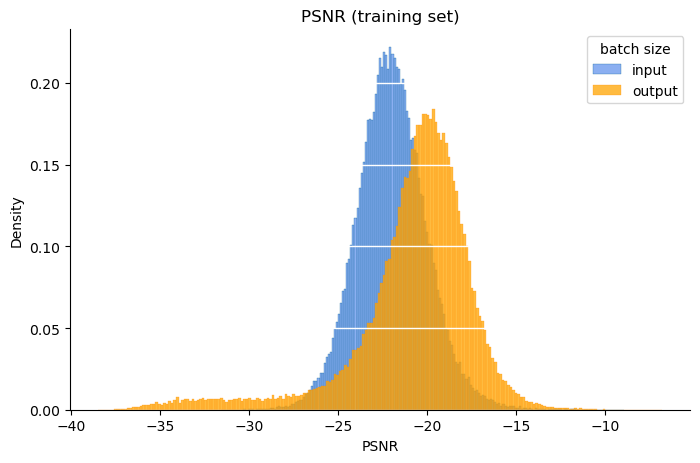

PSNR input (avg:-22.00 std.dev:1.97) vs PSNR output (avg:-20.80 std.dev:3.45)


In [15]:
grayCnn = GrayCNN()
fname = './runs/Oct10_05-34-22_Godel/CvNet_200'
state_dict = torch.load(fname, weights_only=False)
grayCnn.load_state_dict(state_dict)
grayCnn.eval() #with torch_no_grad?

psnrIn, psnrOut = comparePSNR(teGrayDataset, grayCnn, title='PSNR (test set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))

psnrIn, psnrOut = comparePSNR(vlGrayDataset, grayCnn, title='PSNR (validation set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))

psnrIn, psnrOut = comparePSNR(trGrayDataset, grayCnn, title='PSNR (training set)', xlim=(-40,-5))
print('PSNR input (avg:{:.2f} std.dev:{:.2f}) vs PSNR output (avg:{:.2f} std.dev:{:.2f})'.format(np.mean(psnrIn),np.std(psnrIn),  np.mean(psnrOut),np.std(psnrOut)))


In generale il confronto sul PSNR tra l'immagine in ingresso alla rete ed ed il suo output rispetto all'immagine target mostra un miglioramento complessivo della "nitidezza" della foto in esame; inoltre la regolarità degli istogrammi sul training set, validation set e test set suggerisce un comportamento generalizzato della rete addestrata.

Come variante, creiamo un dataframe $\texttt{df}$ formato dalle colonne con psnrIn e psnrOut forniti dal training set, per poi passarlo alla funzione _displot()_ di seaborn in modo che produca una stima 'kde' della densità di probabilità ricavata sui campioni osservati.

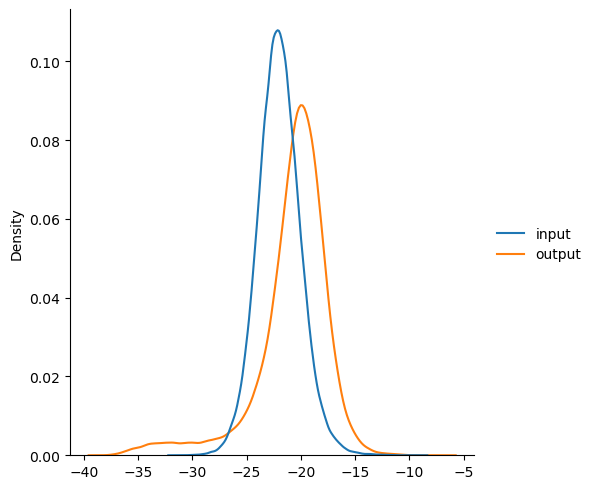

In [17]:
df = pd.DataFrame({'input':psnrIn, 'output':psnrOut})
_ = sns.displot(df, kind='kde', color=['cornflowerblue','orange'] )


## Face-book
Seguono alcuni esempi presi dai tre dataset: in particolare il caso #229 per il training set mostra nella predizione il superamento del valore 1 (chiazze nere nell'angolo in basso a destra, in corrispondenza della regione più chiara dell'immagine). Il fatto che il PSNR peggiori (l'unico caso tra quelli analizzati), nonostante il miglioramento complessivo nel resto dell'immagine, lascia pensare che la coda del PSNR per l'output della rete sia dovuta a questo fenomeno.

In [18]:
def visualizeSR(dataset, index, model):
        (X,y) = dataset.getImages(index)
        p = model(X)
        psnrIn = PSNR(X,y)
        psnrOut = PSNR(p,y)

        # denormalizzo le immagini
        #X = ImageGrayscaleDataset.denormalize(X)
        #y = ImageGrayscaleDataset.denormalize(y)
        fig = plt.figure(figsize=(12,4))
        ax = fig.add_subplot(1, 3, 1)
        plt.imshow(np.array(ToPILImage()(X.to('cpu'))), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('input PSNR {:.3f}'.format(psnrIn))
        
        ax = fig.add_subplot(1, 3, 2)
        plt.imshow(np.array(ToPILImage()(p.to('cpu'))), cmap='gray', vmin=0, vmax=255)
        ax.set_axis_off()
        ax.set_title('output PSNR {:.3f}'.format(psnrOut))
    
        ax = fig.add_subplot(1, 3, 3)
        plt.imshow(np.array(ToPILImage()(y)), cmap='gray', vmin=0, vmax=255)
        ax.set_title('target')
        ax.set_axis_off()
        plt.tight_layout()
        plt.show()



Traning # 29


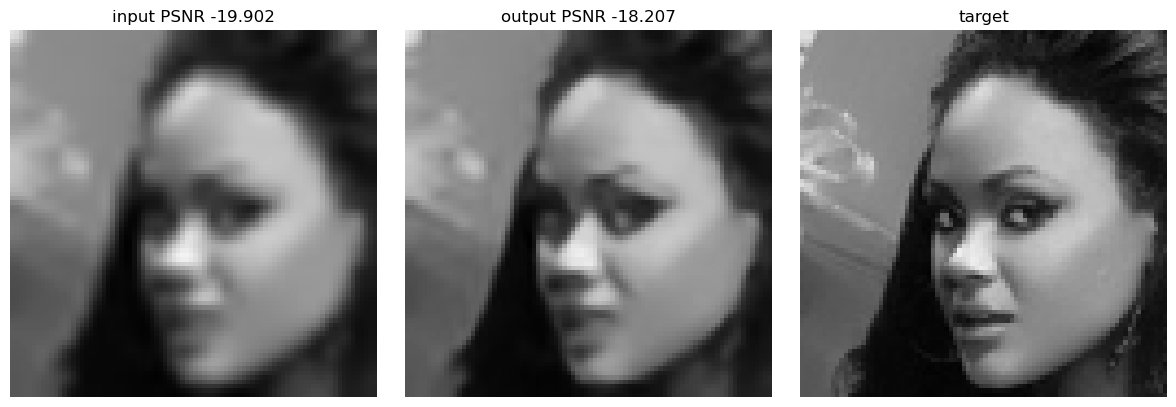


Validation # 29


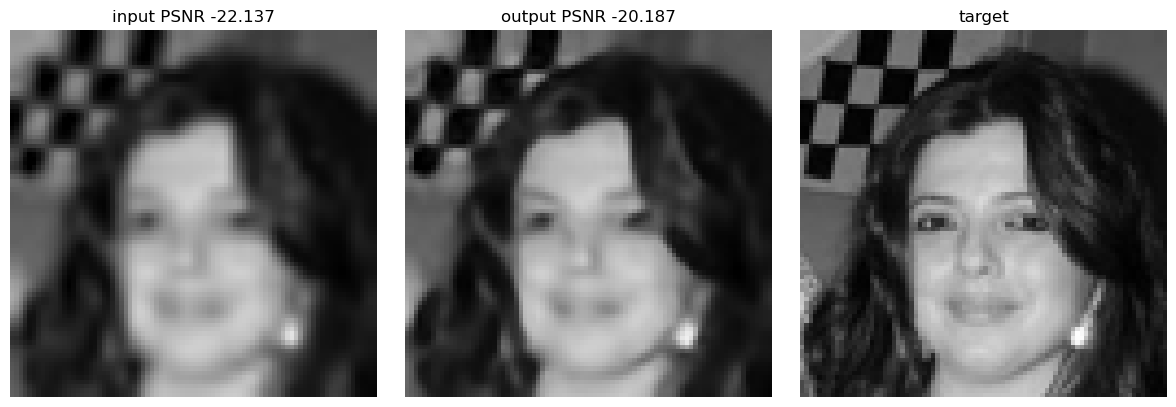


Test # 29


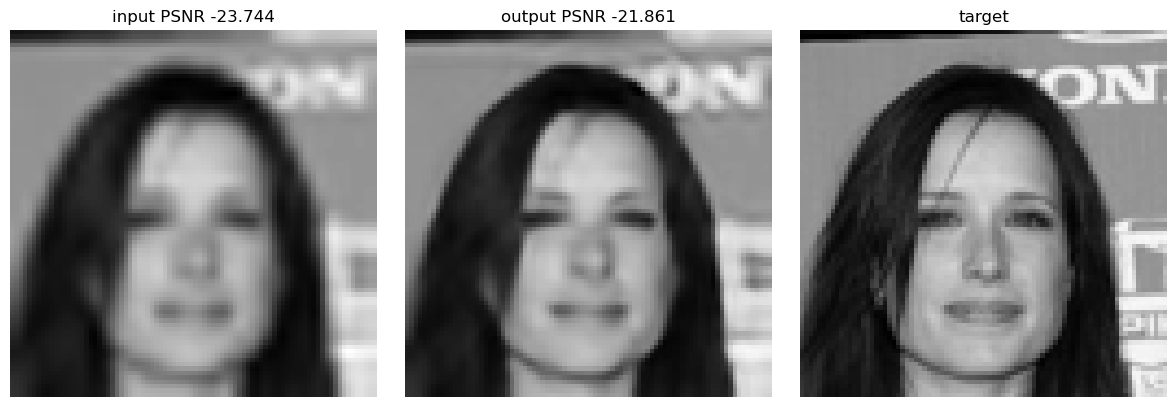


Traning # 229


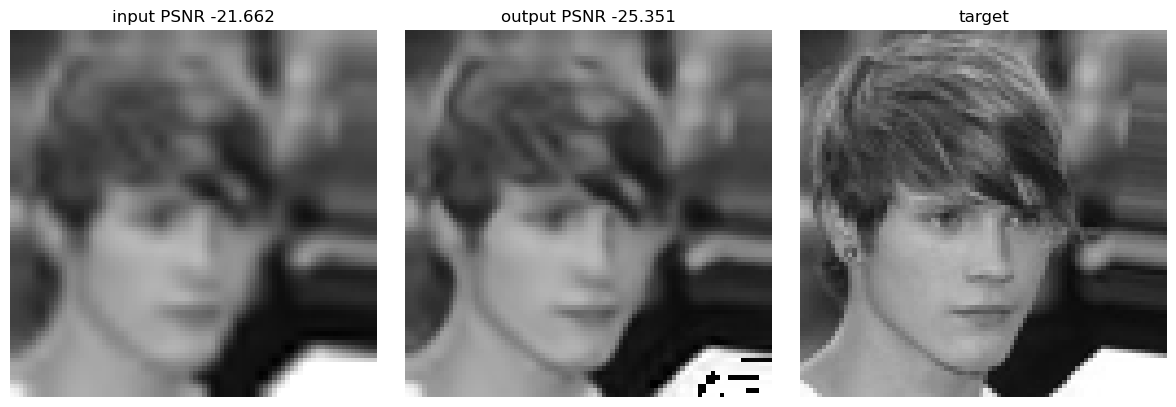


Validation # 229


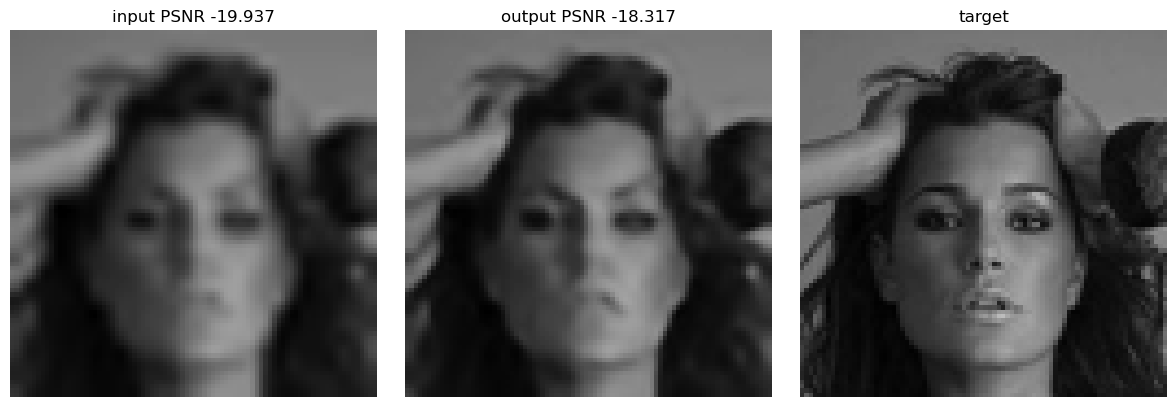


Test # 229


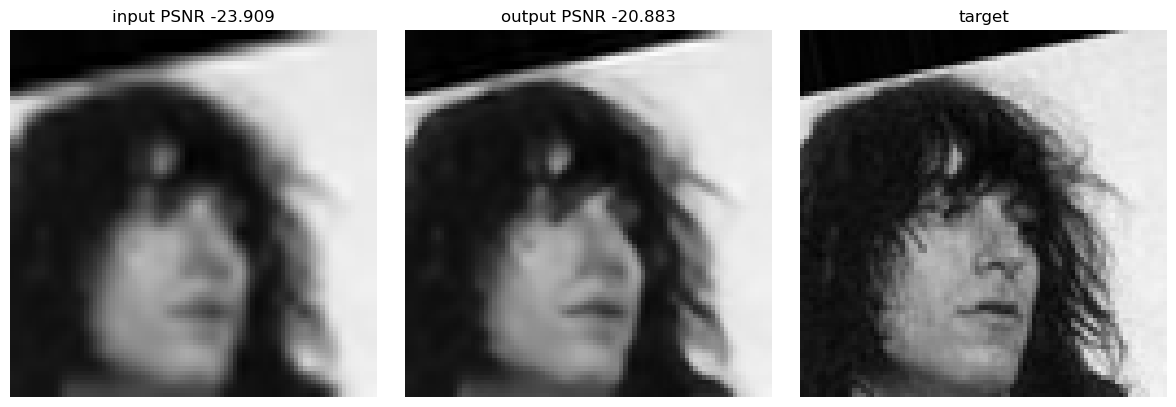


Traning # 429


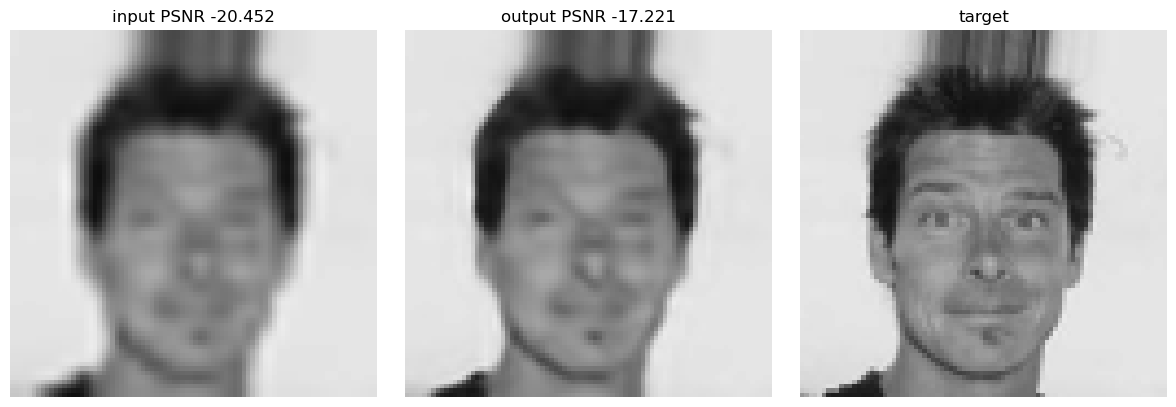


Validation # 429


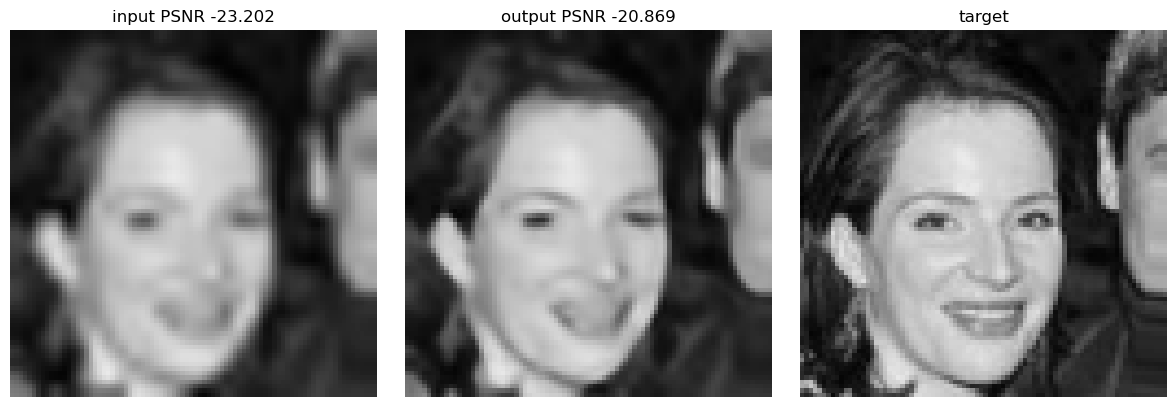


Test # 429


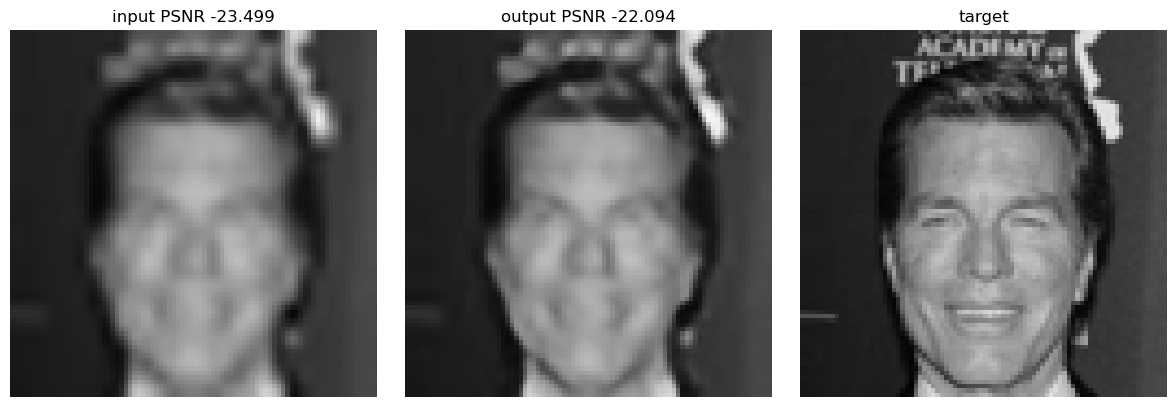


Traning # 629


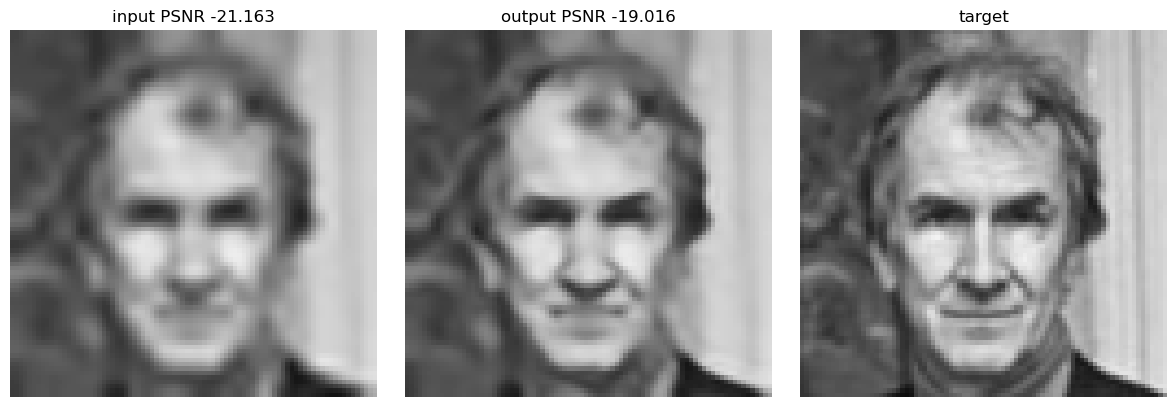


Validation # 629


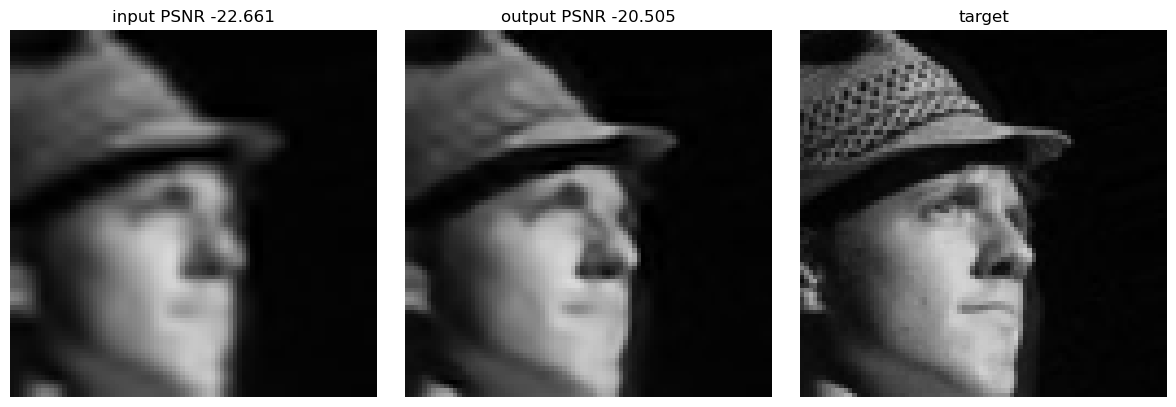


Test # 629


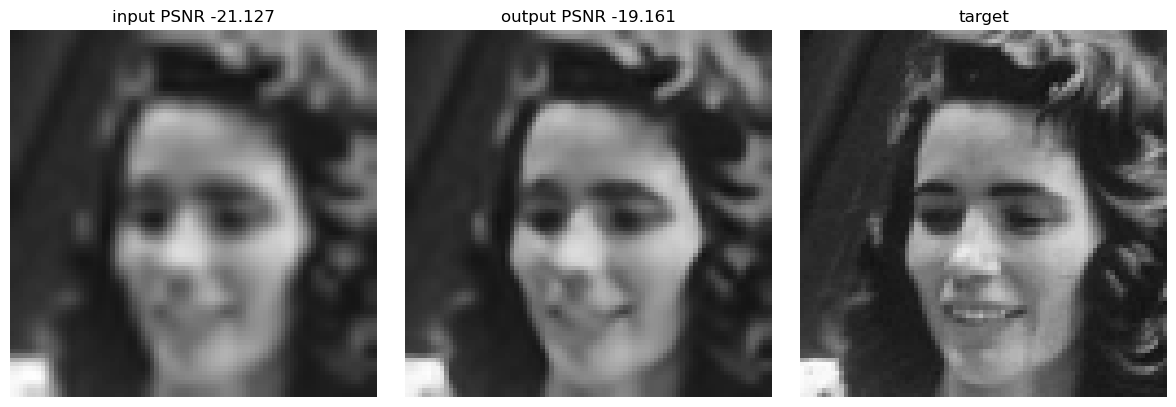


Traning # 829


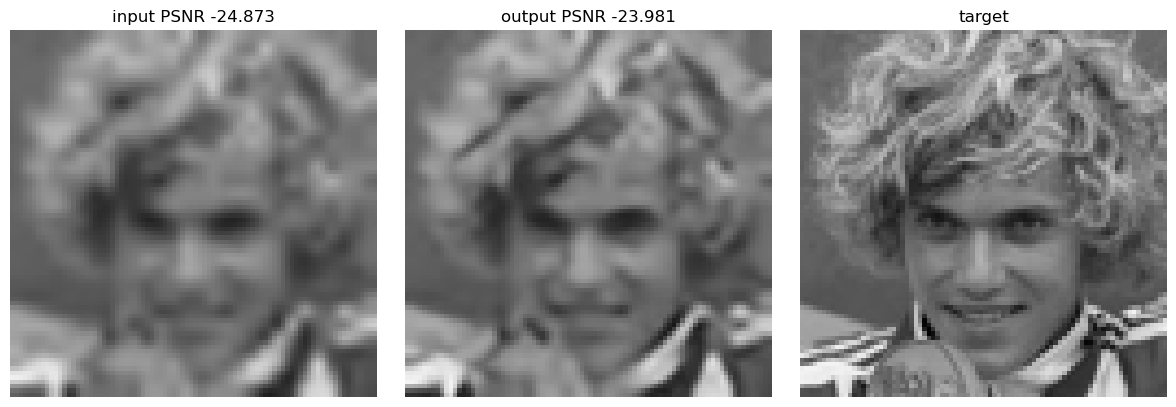


Validation # 829


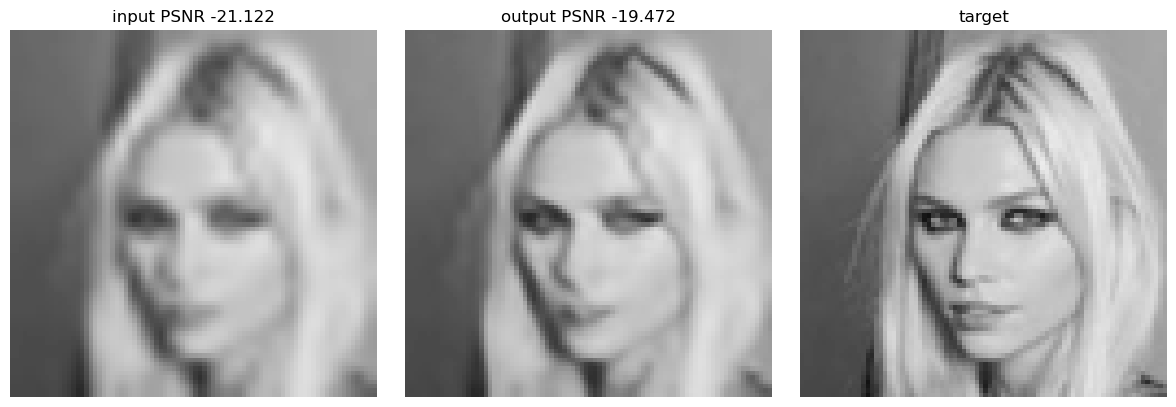


Test # 829


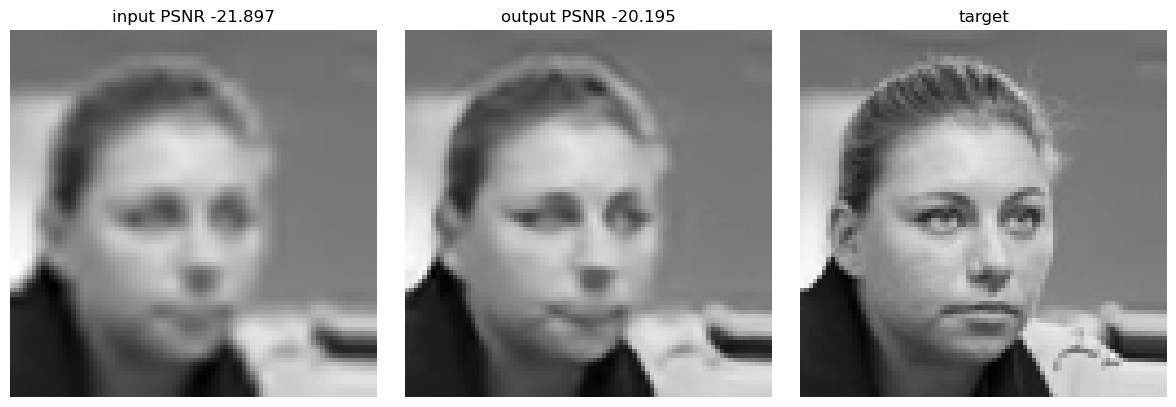

In [19]:
for k in range(5):
    index = 29+k*200
    print('\nTraning # {}'.format(index))
    visualizeSR(trGrayDataset, index, grayCnn)
    #
    print('\nValidation # {}'.format(index))
    visualizeSR(vlGrayDataset, index, grayCnn)
    #
    print('\nTest # {}'.format(index))
    visualizeSR(teGrayDataset, index, grayCnn)